# Load Libraries

In [3]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Display our dataset labels
data = "path to your dataset"
labels_list = [label for label in os.listdir(data)]
print(f"Dataset Labels: {labels_list}")

Dataset Labels: ['sofa', 'jeans', 'tshirt', 'tv']


In [5]:
# Store our dataset images in a list and then output the dataset size
all_images = list()
for i in glob(data+"/*/*"):
    all_images.append(i)
len(all_images)

796

# Define a Function to Generate Images Embeedings

In [7]:
# Loading the Model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

def generate_image_embeddings(myImage):
    """
        This function takes as input an image and returns its embeddings generated via a transfromer based network.

        Params:
            Inputs:
                image : image path, str
            Outputs:
                embeddings : list 
    """
    image = Image.open(myImage).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.tolist()
    return embeddings[0][0]
        

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# create a list to store images and their corresponding embeddings. They are pair as dictionnary
all_data = list()
for index, y in enumerate(all_images):
    all_data.append({
        "image_path" : all_images[index],
        "embeddings" : generate_image_embeddings(all_images[index])
    })
print("Done")

Done


# Transfer Data to Atlas

In [8]:
# Import libraries

import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env file that contain your Atlas cluster credentials
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to your database
db = client.ecommerce_DB

# Get reference to your collection
product_DB_collection = db.products_collections

# Expression that inserts the images+embeddings documents into the collection.
result = product_DB_collection.insert_many(all_data)

document_ids = result.inserted_ids
print("# of documents inserted: "+str(len(document_ids)))
#print(f"_id of inserted document: {document_ids}")
print("Transfer Done!")

#client.close()

# of documents inserted: 796
_id of inserted document: [ObjectId('658e916297ccf9ff48ab2024'), ObjectId('658e916297ccf9ff48ab2025'), ObjectId('658e916297ccf9ff48ab2026'), ObjectId('658e916297ccf9ff48ab2027'), ObjectId('658e916297ccf9ff48ab2028'), ObjectId('658e916297ccf9ff48ab2029'), ObjectId('658e916297ccf9ff48ab202a'), ObjectId('658e916297ccf9ff48ab202b'), ObjectId('658e916297ccf9ff48ab202c'), ObjectId('658e916297ccf9ff48ab202d'), ObjectId('658e916297ccf9ff48ab202e'), ObjectId('658e916297ccf9ff48ab202f'), ObjectId('658e916297ccf9ff48ab2030'), ObjectId('658e916297ccf9ff48ab2031'), ObjectId('658e916297ccf9ff48ab2032'), ObjectId('658e916297ccf9ff48ab2033'), ObjectId('658e916297ccf9ff48ab2034'), ObjectId('658e916297ccf9ff48ab2035'), ObjectId('658e916297ccf9ff48ab2036'), ObjectId('658e916297ccf9ff48ab2037'), ObjectId('658e916297ccf9ff48ab2038'), ObjectId('658e916297ccf9ff48ab2039'), ObjectId('658e916297ccf9ff48ab203a'), ObjectId('658e916297ccf9ff48ab203b'), ObjectId('658e916297ccf9ff48ab20

# Queries

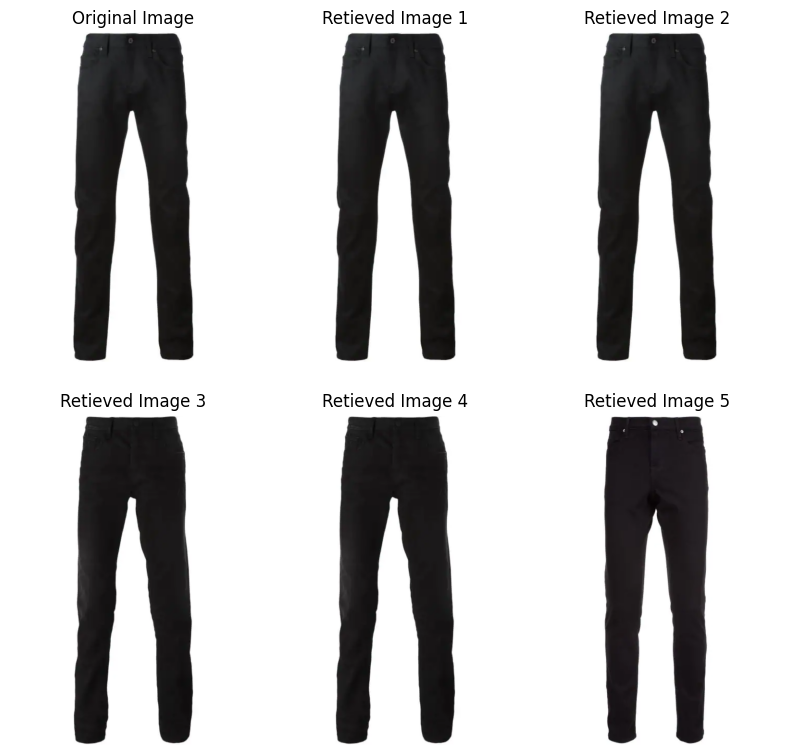

In [20]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env file that contain your Atlas cluster credentials
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to the database
db = client.ecommerce_DB

# Get reference to your collection
product_DB_collection = db.products_collections

# Define the image to query
quering_image = all_images[200]
# Create the querying image embeddings
quering_image_embeddings = generate_image_embeddings(quering_image)

# Aggregation to retrieve similar images from your Atlas cluster.
# 5 similar images are retrieved via VectorSearch. Cosine similarity is used for distance calculation
results = product_DB_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": quering_image_embeddings,
    "path": "embeddings",
    "numCandidates": 5,
    "limit": 5,
    "index": "ecommerce_products_similarity_serach",
      }}
])

# Plotting the retrieved images
images_to_plot = [quering_image]
count = 1
for document in results:
    #print(f"RESPONSE {count}:{document['image_path']} \n")
    count += 1
    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Retieved Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()

# Uncomment below line of code to close your db connection
#client.close

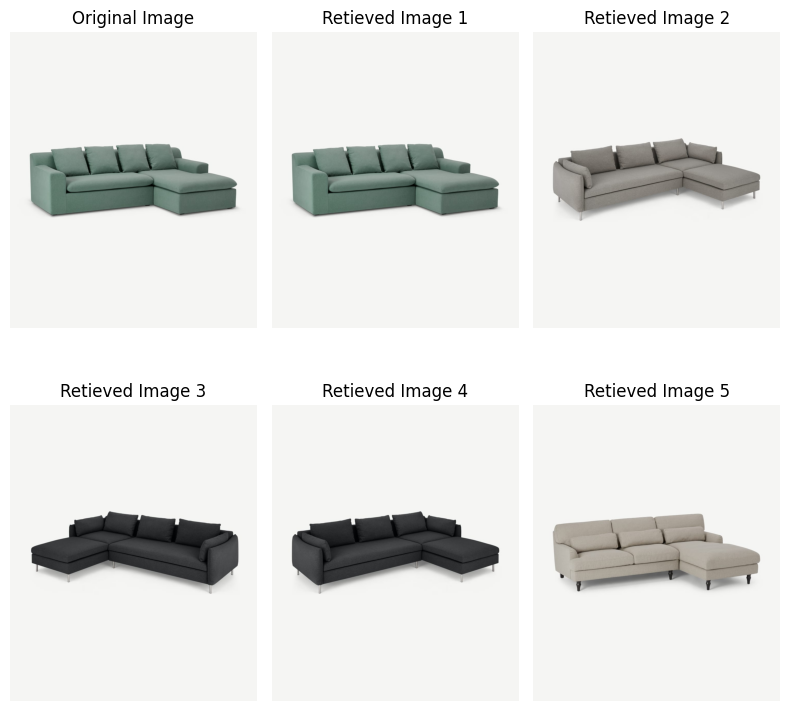

In [21]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env file that contain your Atlas cluster credentials
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to the database
db = client.ecommerce_DB

# Get reference to your collection
product_DB_collection = db.products_collections

# Define the image to query
quering_image = all_images[0]
# Create the querying image embeddings
quering_image_embeddings = generate_image_embeddings(quering_image)

# Aggregation to retrieve similar images from your Atlas cluster.
# 5 similar images are retrieved via VectorSearch. Cosine similarity is used for distance calculation
results = product_DB_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": quering_image_embeddings,
    "path": "embeddings",
    "numCandidates": 5,
    "limit": 5,
    "index": "ecommerce_products_similarity_serach",
      }}
])

# Plotting the retrieved images
images_to_plot = [quering_image]
count = 1
for document in results:
    #print(f"RESPONSE {count}:{document['image_path']} \n")
    count += 1
    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Retieved Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()

# Uncomment below line of code to close your db connection
#client.close

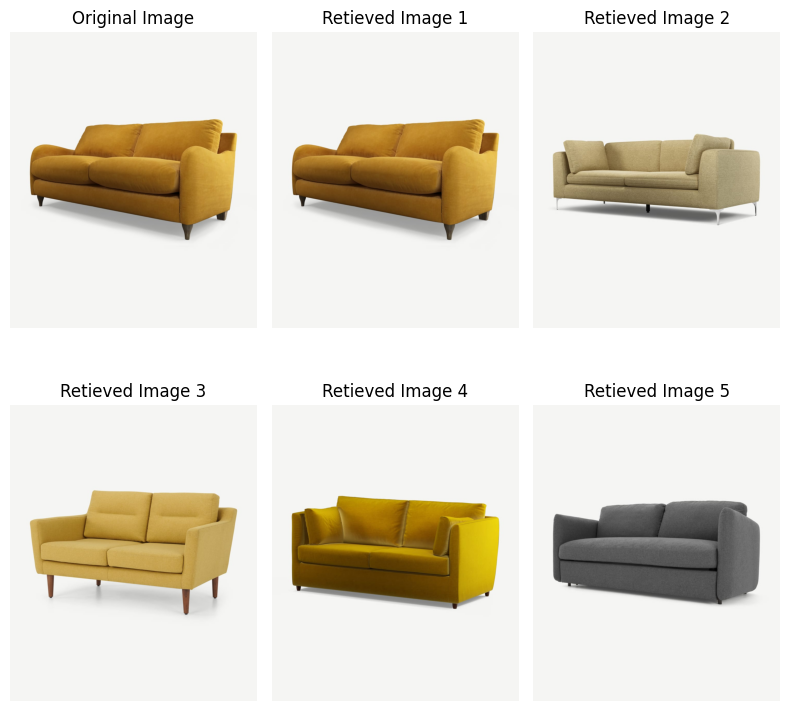

In [22]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env file that contain your Atlas cluster credentials
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to the database
db = client.ecommerce_DB

# Get reference to your collection
product_DB_collection = db.products_collections

# Define the image to query
quering_image = all_images[27]
# Create the querying image embeddings
quering_image_embeddings = generate_image_embeddings(quering_image)

# Aggregation to retrieve similar images from your Atlas cluster.
# 5 similar images are retrieved via VectorSearch. Cosine similarity is used for distance calculation
results = product_DB_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": quering_image_embeddings,
    "path": "embeddings",
    "numCandidates": 5,
    "limit": 5,
    "index": "ecommerce_products_similarity_serach",
      }}
])

# Plotting the retrieved images
images_to_plot = [quering_image]
count = 1
for document in results:
    #print(f"RESPONSE {count}:{document['image_path']} \n")
    count += 1
    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Retieved Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()

# Uncomment below line of code to close your db connection
#client.close

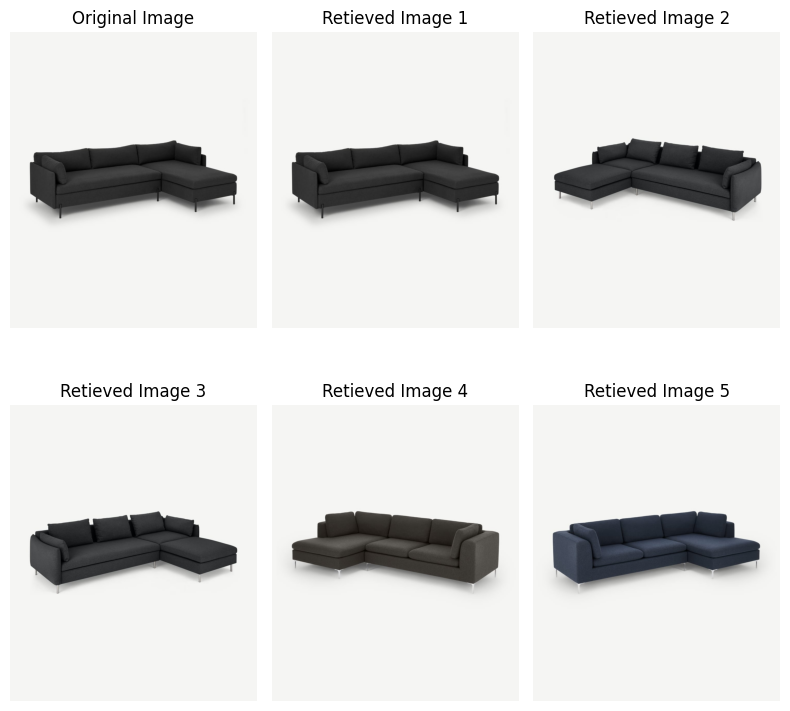

In [25]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env file that contain your Atlas cluster credentials
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to the database
db = client.ecommerce_DB

# Get reference to your collection
product_DB_collection = db.products_collections

# Define the image to query
quering_image = all_images[79]
# Create the querying image embeddings
quering_image_embeddings = generate_image_embeddings(quering_image)

# Aggregation to retrieve similar images from your Atlas cluster.
# 5 similar images are retrieved via VectorSearch. Cosine similarity is used for distance calculation
results = product_DB_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": quering_image_embeddings,
    "path": "embeddings",
    "numCandidates": 5,
    "limit": 5,
    "index": "ecommerce_products_similarity_serach",
      }}
])

# Plotting the retrieved images
images_to_plot = [quering_image]
count = 1
for document in results:
    #print(f"RESPONSE {count}:{document['image_path']} \n")
    count += 1
    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Retieved Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()

# Uncomment below line of code to close your db connection
#client.close

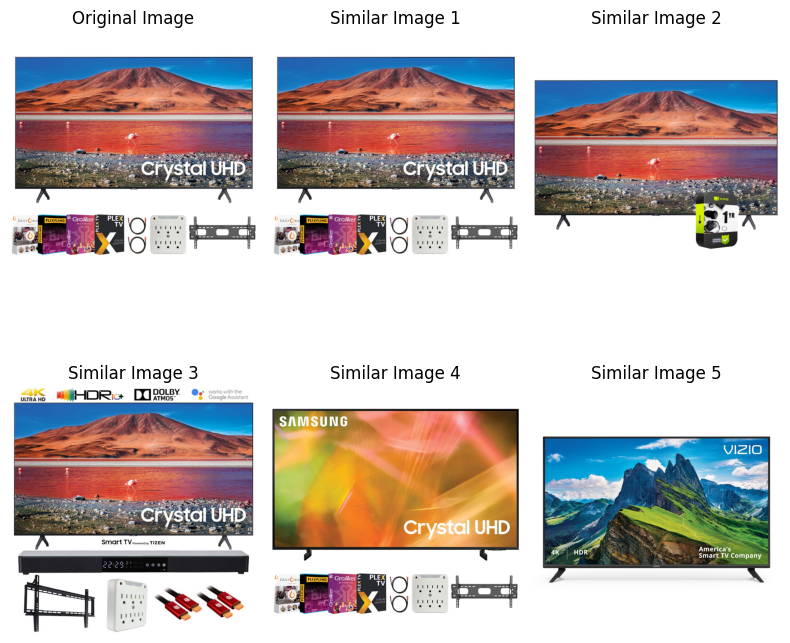

In [24]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load config from .env file
load_dotenv()
MONGODB_URI = os.environ["MONGODB_URI"]

# Connect to MongoDB cluster with MongoClient
client = MongoClient(MONGODB_URI)

# Get reference to the database
db = client.ecommerce_DB

# Get reference to 'label_type_30A' collection
product_DB_collection = db.products_collections

quering_image = all_images[760]
quering_image_embeddings = generate_image_embeddings(quering_image)

results = product_DB_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": quering_image_embeddings,
    "path": "embeddings",
    "numCandidates": 5,
    "limit": 5,
    "index": "ecommerce_products_similarity_serach",
      }}
])

images_to_plot = [quering_image]
count = 1
for document in results:
    #print(f"RESPONSE {count}:{document['image_path']} \n")
    count += 1
    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Similar Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()